Using the same randomly generated dataset, instead of stochastic gradient descent let's optimize our neural net with minibatch.

https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

In [2]:
# IMPORT PACKAGES

# Import relevant packages

%matplotlib inline
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from imutils import paths
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D, ZeroPadding2D
from keras.optimizers import RMSprop, adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils,to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.metrics import binary_accuracy,binary_crossentropy
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l2 # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation
from sklearn import svm
import random 
import argparse
import datetime
import imutils
import cv2
import os
import re
import shutil
from IPython.display import Image
K.set_image_dim_ordering('th')

### Simulate data

In [3]:
# set seed
np.random.seed(12)
n = 10000

x_1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], n)
x_2 = np.random.multivariate_normal([1, 4], [[2, .75],[.75, 2]], n)
x_3 = np.random.multivariate_normal([2, 8], [[3, .75],[.75, 3]], n)

simulated_separableish_features = np.vstack((x_1, x_2, x_3)).astype(np.float32)
y = np.hstack((np.zeros(n),
               np.ones(n),
              np.ones(n)+1))


In [4]:
print(x_1.shape,x_2.shape,x_3.shape)
print(y.shape)

(10000, 2) (10000, 2) (10000, 2)
(30000,)


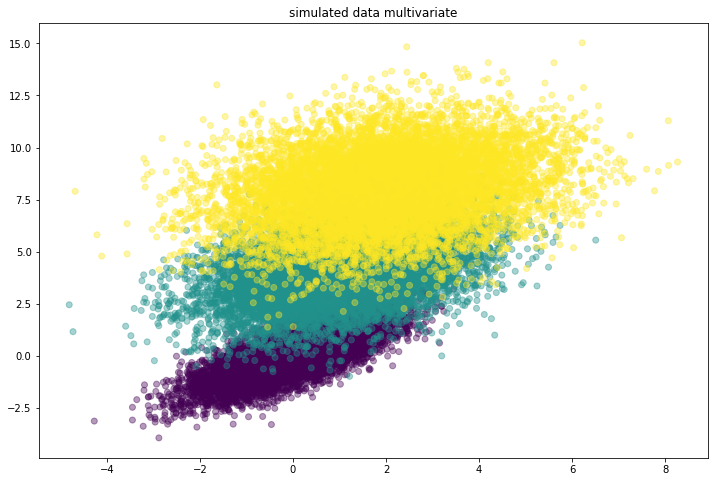

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = y, alpha = .4)
plt.title("simulated data multivariate")

In [16]:
n_feature = 2
n_class = 3
n_iter = 10


def make_network(n_hidden=5):
    # Initialize weights with Standard Normal random variables
    model = dict(
        W1=np.random.randn(n_feature, n_hidden),
        W2=np.random.randn(n_hidden, n_class)
    )

    return model

### Define forward propagation

In [7]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()


def forward(x, model):
    # Input to hidden
    h = x @ model['W1']
    # ReLU non-linearity
    h[h < 0] = 0

    # Hidden to output
    prob = softmax(h @ model['W2'])

    return h, prob

### Define backward propagation

In [8]:
def backward(model, xs, hs, errs):
    """xs, hs, errs contain all informations (input, hidden state, error) of all data in the minibatch"""
    # errs is the gradients of output layer for the minibatch
    dW2 = hs.T @ errs

    # Get gradient of hidden layer
    dh = errs @ model['W2'].T
    dh[hs <= 0] = 0

    dW1 = xs.T @ dh

    return dict(W1=dW1, W2=dW2)

### Implementing the Minibatch Gradient Descent


In [9]:
def sgd(model, X_train, y_train, minibatch_size):
    for iter in range(n_iter):
        print('Iteration {}'.format(iter))

        # Randomize data point
        X_train, y_train = shuffle(X_train, y_train)

        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current minibatch/chunk
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]

            model = sgd_step(model, X_train_mini, y_train_mini)

    return model

In [26]:
def sgd_step(model, X_train, y_train):
    grad = get_minibatch_grad(model, X_train, y_train)
    model = model.copy()

    # Update every parameters in our networks (W1 and W2) using their gradients
    for layer in grad:
        # Learning rate: 1e-4
        model[layer] += 1e-4 * grad[layer]

    return model

In [11]:
def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)

        # Create probability distribution of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of minibatch
        # x: input
        # h: hidden state
        # err: gradient of output layer
        xs.append(x)
        hs.append(h)
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs), np.array(errs))

### Testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, y, test_size=0.2, random_state=42)

In [29]:
minibatch_size = 50
n_experiment = 1 # 100

import time
start = time.time()
# Create placeholder to accumulate prediction accuracy
accs = np.zeros(n_experiment)

for k in range(n_experiment):
    # Reset model
    model = make_network()

    # Train the model
    model = sgd(model, X_train, y_train, minibatch_size)

    y_pred = np.zeros_like(y_test)

    for i, x in enumerate(X_test):
        # Predict the distribution of label
        _, prob = forward(x, model)
        # Get label by picking the most probable one
        y = np.argmax(prob)
        y_pred[i] = y

    # Compare the predictions with the true labels and take the percentage
    accs[k] = (y_pred == y_test).sum() / y_test.size

print('Mean accuracy: {}%, std: {}'.format(accs.mean()*100, accs.std()))

end = time.time()
print(end - start)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Mean accuracy: 61.06666666666667%, std: 0.0
7.75744891166687
